In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="4"
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

import time
import numpy as np
import gc
import sys
sys.setrecursionlimit(50000)
import pickle
import random
torch.set_default_tensor_type('torch.cuda.FloatTensor')
torch.nn.Module.dump_patches = True
import copy
import pandas as pd
from sklearn.model_selection import KFold

#then import my own modules
# from AttentiveFP import Fingerprint, Fingerprint_viz, save_smiles_dicts, get_smiles_dicts, get_smiles_array, moltosvg_highlight
from timeit import default_timer as timer
from AttentiveFP import Fingerprint, Fingerprint_viz, graph_dict, graph_dataset, null_collate, Graph, Logger, time_to_str


In [2]:
cuda_aviable = torch.cuda.is_available()
device = torch.device(0)

SEED = 8
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True
torch.backends.cudnn.deterministic=True


In [3]:
from rdkit import Chem
# from rdkit.Chem import AllChem
from rdkit.Chem import QED
from rdkit.Chem import rdMolDescriptors, MolSurf
from rdkit.Chem.Draw import SimilarityMaps
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
%matplotlib inline
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
import seaborn as sns; sns.set()
from IPython.display import SVG, display
import sascorer

number of all smiles:  1128
number of successfully processed smiles:  1128


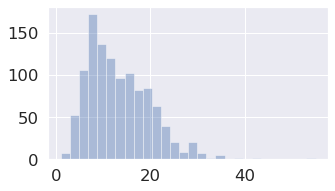

In [4]:
task_name = 'solubility'
tasks = ['measured log solubility in mols per litre']

raw_filename = "../data/delaney-processed.csv"
feature_filename = raw_filename.replace('.csv','.pickle')
filename = raw_filename.replace('.csv','')
prefix_filename = raw_filename.split('/')[-1].replace('.csv','')
smiles_tasks_df = pd.read_csv(raw_filename)
smilesList = smiles_tasks_df.smiles.values
print("number of all smiles: ", len(smilesList))
atom_num_dist = []
remained_smiles = []
canonical_smiles_list = []
for smiles in smilesList:
    try:        
        mol = Chem.MolFromSmiles(smiles)
        atom_num_dist.append(len(mol.GetAtoms()))
        remained_smiles.append(smiles)
        canonical_smiles_list.append(Chem.MolToSmiles(Chem.MolFromSmiles(smiles), isomericSmiles=True))
    except:
        print(smiles)
        pass
print("number of successfully processed smiles: ", len(remained_smiles))

smiles_tasks_df = smiles_tasks_df[smiles_tasks_df["smiles"].isin(remained_smiles)].reset_index()
smiles_tasks_df['cano_smiles'] =canonical_smiles_list
plt.figure(figsize=(5, 3))
sns.set(font_scale=1.5)
ax = sns.distplot(atom_num_dist, bins=28, kde=False)
plt.tight_layout()
plt.show()
plt.close()


In [5]:
start_time = str(time.ctime()).replace(':','-').replace(' ','_')

epochs = 80
batch_size =50

p_dropout= 0.2
fingerprint_dim = 200

weight_decay = 5 # also known as l2_regularization_lambda
learning_rate = 3
K = 3
T = 2
per_task_output_units_num = 1 # for regression model
output_units_num = len(tasks) * per_task_output_units_num

In [6]:
smiles_list = smiles_tasks_df['smiles'].values
label_list = smiles_tasks_df[tasks[0]].values
graph_dict = graph_dict(smiles_list, label_list, filename)


graph dicts loaded from ../data/delaney-processed.pkl


In [7]:
kfold = KFold(n_splits=5, shuffle=True, random_state=SEED)
train_fold = []
valid_fold = []
for k, (train_idx, valid_idx) in enumerate(kfold.split(smiles_list)):
    train_fold.append(train_idx)
    valid_fold.append(valid_idx)
    
# avoiding the last batch has too few samples by slightly tune the batch_size
while (len(train_fold[0]) % batch_size) / batch_size <0.8:
    batch_size +=1
print("batch size: ", batch_size)

batch size:  57


In [8]:
loss_function = nn.MSELoss()
model = Fingerprint(output_units_num, fingerprint_dim, K=K, T=T, p_dropout=p_dropout)
model.to(device)

# optimizer = optim.Adam(model.parameters(), learning_rate, weight_decay=weight_decay)
optimizer = optim.Adam(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)
# optimizer = optim.SGD(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)

# model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in  model.parameters()])
print(params)
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data.shape)
        

1604858
atom_preprocess.preprocess.0.linear.weight torch.Size([200, 39])
atom_preprocess.preprocess.0.linear.bias torch.Size([200])
atom_preprocess.preprocess.0.bn.weight torch.Size([200])
atom_preprocess.preprocess.0.bn.bias torch.Size([200])
atom_preprocess.preprocess.3.linear.weight torch.Size([200, 200])
atom_preprocess.preprocess.3.linear.bias torch.Size([200])
atom_preprocess.preprocess.3.bn.weight torch.Size([200])
atom_preprocess.preprocess.3.bn.bias torch.Size([200])
bond_preprocess.preprocess.0.linear.weight torch.Size([200, 10])
bond_preprocess.preprocess.0.linear.bias torch.Size([200])
bond_preprocess.preprocess.0.bn.weight torch.Size([200])
bond_preprocess.preprocess.0.bn.bias torch.Size([200])
bond_preprocess.preprocess.3.linear.weight torch.Size([200, 200])
bond_preprocess.preprocess.3.linear.bias torch.Size([200])
bond_preprocess.preprocess.3.bn.weight torch.Size([200])
bond_preprocess.preprocess.3.bn.bias torch.Size([200])
align.linear.weight torch.Size([1, 800])
align

In [9]:
def train(smiles_list):
    model.train()
    train_loader = DataLoader(graph_dataset(smiles_list, graph_dict), batch_size, collate_fn=null_collate, \
                              num_workers=8, pin_memory=True, shuffle=True, worker_init_fn=np.random.seed(SEED))
    losses = []
    for b, (smiles, atom, bond, bond_index, mol_index, label) in enumerate(train_loader):
        atom = atom.to(device)
        bond = bond.to(device)
        bond_index = bond_index.to(device)
        mol_index = mol_index.to(device)
        label = label.to(device)
        
        mol_prediction = model(atom, bond, bond_index, mol_index)
        
        loss = loss_function(mol_prediction, label.view(-1,1))     
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss.item())

    return np.mean(losses)

        
def eval(smiles_list):
    model.eval()
    eval_MAE_list = []
    eval_MSE_list = []
    eval_loader = DataLoader(graph_dataset(smiles_list, graph_dict), batch_size, collate_fn=null_collate, \
                              num_workers=8, pin_memory=True, shuffle=False, worker_init_fn=np.random.seed(SEED))
    for b, (smiles, atom, bond, bond_index, mol_index, label) in enumerate(eval_loader):
        atom = atom.to(device)
        bond = bond.to(device)
        bond_index = bond_index.to(device)
        mol_index = mol_index.to(device)
        label = label.to(device)
        
        mol_prediction = model(atom, bond, bond_index, mol_index)
        MAE = F.l1_loss(mol_prediction, label.view(-1,1), reduction='none')        
        MSE = F.mse_loss(mol_prediction, label.view(-1,1), reduction='none')
        
        eval_MAE_list.extend(MAE.data.squeeze().cpu().numpy())
        eval_MSE_list.extend(MSE.data.squeeze().cpu().numpy())
    return np.array(eval_MAE_list).mean(), np.array(eval_MSE_list).mean()


In [10]:
# log = Logger()
# log.open(f'{prefix_filename}_{start_time}.txt')

# f = '{:^5} | {:^7.4f} | {:^7.4f} | {:^7.4f} | {:^7} \n'
# log.write('epoch | loss | train MSE |  valid MSE |  time \n')
# start = timer()

# best_param ={}
# best_param["train_epoch"] = 0
# best_param["valid_epoch"] = 0
# best_param["train_MSE"] = 9e8
# best_param["valid_MSE"] = 9e8

# fold_index = 3
# for epoch in range(800):
#     losses = train(smiles_list[train_fold[fold_index]])
#     traine_MAE, train_MSE = eval(smiles_list[train_fold[fold_index]])
#     valid_MAE, valid_MSE = eval(smiles_list[valid_fold[fold_index]])

#     timing = time_to_str((timer() - start), 'min')  
#     log.write(f.format(epoch, losses, train_MSE, valid_MSE, timing))

#     if train_MSE < best_param["train_MSE"]:
#         best_param["train_epoch"] = epoch
#         best_param["train_MSE"] = train_MSE
#     if valid_MSE < best_param["valid_MSE"]:
#         best_param["valid_epoch"] = epoch
#         best_param["valid_MSE"] = valid_MSE
# #         if valid_MSE < 0.35:
# #              torch.save(model, 'saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(epoch)+'.pt')
#     if (epoch - best_param["train_epoch"] >10) and (epoch - best_param["valid_epoch"] >18):        
#         break
# print(best_param["valid_epoch"],best_param["train_MSE"],best_param["valid_MSE"])

In [11]:

log = Logger()
log.open(f'log/{prefix_filename}_{start_time}.txt')

f = '{:^5} | {:^7.4f} | {:^7.4f} | {:^7.4f} | {:^7} \n'
log.write('epoch | loss | train MSE |  valid MSE |  time \n')
start = timer()

log2 = Logger()
log2.open(f'{prefix_filename}_best_{start_time}.txt')
f2 = '{:^5} | {:^5} | {:^7.4f} | {:^7.4f} \n'

for fold_index in range(5):
    
    model = Fingerprint(output_units_num, fingerprint_dim, K=K, T=T, p_dropout=p_dropout)
    model.to(device)

    optimizer = optim.Adam(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)
    
    best_param ={}
    best_param["train_epoch"] = 0
    best_param["valid_epoch"] = 0
    best_param["train_MSE"] = 800
    best_param["valid_MSE"] = 800
    for epoch in range(800):
        losses = train(smiles_list[train_fold[fold_index]])
        traine_MAE, train_MSE = eval(smiles_list[train_fold[fold_index]])
        valid_MAE, valid_MSE = eval(smiles_list[valid_fold[fold_index]])
        
        timing = time_to_str((timer() - start), 'min')  
        log.write(f.format(epoch, losses, train_MSE, valid_MSE, timing))
        
        if train_MSE < best_param["train_MSE"]:
            best_param["train_epoch"] = epoch
            best_param["train_MSE"] = train_MSE
        if valid_MSE < best_param["valid_MSE"]:
            best_param["valid_epoch"] = epoch
            best_param["valid_MSE"] = valid_MSE
#             if valid_MSE < 0.35:
#                  torch.save(model, 'saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(epoch)+'.pt')
        if (epoch - best_param["train_epoch"] >10) and (epoch - best_param["valid_epoch"] >18):        
            break

    log2.write('fold | epoch | train_MSE | valid MSE \n')
    log2.write(f2.format(fold_index, best_param["valid_epoch"],best_param["train_MSE"],best_param["valid_MSE"]))
    
    

epoch | loss | train MSE |  valid MSE |  time 
  0   | 6.5960  | 3.2545  | 3.9979  |  0 hr 00 min 
  1   | 1.7161  | 1.9498  | 2.3593  |  0 hr 00 min 
  2   | 1.2046  | 0.7958  | 0.9786  |  0 hr 00 min 
  3   | 0.8993  | 0.8122  | 1.0397  |  0 hr 00 min 
  4   | 0.7933  | 0.6088  | 0.6504  |  0 hr 00 min 
  5   | 0.6913  | 0.7278  | 0.8285  |  0 hr 00 min 
  6   | 0.7355  | 0.5812  | 0.6792  |  0 hr 00 min 
  7   | 0.6172  | 0.3893  | 0.6071  |  0 hr 00 min 
  8   | 0.5323  | 0.2932  | 0.4175  |  0 hr 00 min 
  9   | 0.5175  | 0.6689  | 0.7775  |  0 hr 00 min 
 10   | 0.5568  | 0.3743  | 0.5377  |  0 hr 00 min 
 11   | 0.4669  | 0.3096  | 0.4304  |  0 hr 00 min 
 12   | 0.5134  | 0.2894  | 0.5025  |  0 hr 00 min 
 13   | 0.4292  | 0.2606  | 0.5086  |  0 hr 00 min 
 14   | 0.4796  | 0.2742  | 0.5075  |  0 hr 00 min 
 15   | 0.3931  | 0.2411  | 0.4606  |  0 hr 00 min 
 16   | 0.4385  | 0.2663  | 0.4750  |  0 hr 00 min 
 17   | 0.3903  | 0.2302  | 0.4546  |  0 hr 00 min 
 18   | 0.4214  |

  6   | 0.6307  | 0.6177  | 0.7481  |  0 hr 07 min 
  7   | 0.4875  | 0.4333  | 0.7090  |  0 hr 07 min 
  8   | 0.5716  | 0.3460  | 0.5685  |  0 hr 07 min 
  9   | 0.5350  | 0.2903  | 0.4686  |  0 hr 07 min 
 10   | 0.5814  | 0.3633  | 0.5154  |  0 hr 07 min 
 11   | 0.4706  | 0.3293  | 0.4886  |  0 hr 07 min 
 12   | 0.5350  | 0.3245  | 0.5365  |  0 hr 07 min 
 13   | 0.5144  | 0.2575  | 0.4384  |  0 hr 07 min 
 14   | 0.3801  | 0.2568  | 0.4627  |  0 hr 07 min 
 15   | 0.4340  | 0.3094  | 0.5275  |  0 hr 07 min 
 16   | 0.4997  | 0.2845  | 0.4872  |  0 hr 07 min 
 17   | 0.4715  | 0.2643  | 0.4547  |  0 hr 07 min 
 18   | 0.3996  | 0.2553  | 0.4556  |  0 hr 07 min 
 19   | 0.4550  | 0.2434  | 0.4620  |  0 hr 07 min 
 20   | 0.4197  | 0.2010  | 0.4278  |  0 hr 07 min 
 21   | 0.4776  | 0.2441  | 0.5015  |  0 hr 07 min 
 22   | 0.4069  | 0.2649  | 0.4637  |  0 hr 08 min 
 23   | 0.3198  | 0.2212  | 0.4692  |  0 hr 08 min 
 24   | 0.3677  | 0.1980  | 0.4369  |  0 hr 08 min 
 25   | 0.34

 80   | 0.3061  | 0.1373  | 0.3085  |  0 hr 15 min 
 81   | 0.2420  | 0.0887  | 0.2667  |  0 hr 15 min 
 82   | 0.2875  | 0.0922  | 0.2429  |  0 hr 15 min 
 83   | 0.1760  | 0.0657  | 0.2193  |  0 hr 15 min 
 84   | 0.2318  | 0.1153  | 0.2966  |  0 hr 15 min 
 85   | 0.2059  | 0.1510  | 0.3001  |  0 hr 15 min 
 86   | 0.2509  | 0.0854  | 0.2562  |  0 hr 15 min 
 87   | 0.1871  | 0.0809  | 0.2465  |  0 hr 15 min 
 88   | 0.3271  | 0.1492  | 0.2850  |  0 hr 15 min 
 89   | 0.1836  | 0.0835  | 0.2618  |  0 hr 15 min 
 90   | 0.2112  | 0.0730  | 0.2466  |  0 hr 15 min 
 91   | 0.2305  | 0.0954  | 0.2688  |  0 hr 15 min 
 92   | 0.2290  | 0.0841  | 0.2600  |  0 hr 15 min 
 93   | 0.1704  | 0.0574  | 0.2334  |  0 hr 15 min 
 94   | 0.2426  | 0.0879  | 0.2599  |  0 hr 15 min 
 95   | 0.1753  | 0.0676  | 0.2576  |  0 hr 15 min 
 96   | 0.2491  | 0.1169  | 0.2631  |  0 hr 15 min 
 97   | 0.1782  | 0.0616  | 0.2554  |  0 hr 15 min 
 98   | 0.2005  | 0.0546  | 0.2500  |  0 hr 16 min 
 99   | 0.17

  4   |  79   | 0.0494  | 0.4320  


In [12]:
# # evaluate model
# best_model = torch.load('saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(best_param["valid_epoch"])+'.pt')     

# best_model_dict = best_model.state_dict()
# best_model_wts = copy.deepcopy(best_model_dict)

# model.load_state_dict(best_model_wts)
# (best_model.align[0].weight == model.align[0].weight).all()
# test_MAE, test_MSE = eval(model, test_df)
# print("best epoch:",best_param["test_epoch"],"\n","test MSE:",test_MSE)

In [13]:
# for e in range(20):
#     losses = train(smiles_list[valid_fold[fold_index]])
#     print(losses)